In [1]:
from google.colab import drive
import os

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Create your project folder
# This ensures the path exists before the AI tries to save there
project_path = '/content/drive/MyDrive/AISF_Project'
os.makedirs(project_path, exist_ok=True)
os.makedirs(f"{project_path}/checkpoints", exist_ok=True)
os.makedirs(f"{project_path}/logs", exist_ok=True)

print(f"✅ Drive mounted. Files will be saved to: {project_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted. Files will be saved to: /content/drive/MyDrive/AISF_Project


In [2]:
# 1. Install system-level dependencies (SWIG is the fix for your error)
!apt-get update && apt-get install -y swig python3-dev xvfb ffmpeg

# 2. Install Python libraries
!pip install gymnasium[box2d] stable-baselines3[extra] pyvirtualdisplay

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 7,549 B in 2s (3,969 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.

In [3]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
import os

# 1. Setup Environment again (This defines 'env_sac')
log_dir = "./logs/sac_tuned/"
os.makedirs(log_dir, exist_ok=True)

def make_env():
    env = gym.make("BipedalWalker-v3")
    env = Monitor(env, log_dir)
    return env

# Vectorize and Normalize
env_sac = DummyVecEnv([make_env])
env_sac = VecNormalize(env_sac, norm_obs=True, norm_reward=True, clip_obs=10.)

print("✅ SAC imported and env_sac defined. You are ready to train!")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/us

✅ SAC imported and env_sac defined. You are ready to train!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
import os
from stable_baselines3.common.callbacks import CheckpointCallback

# 1. ENSURE DIRECTORIES EXIST (Crucial Step)
base_path = '/content/drive/MyDrive/AISF_Project'
checkpoint_path = os.path.join(base_path, 'checkpoints')
log_path = os.path.join(base_path, 'logs')

os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

# 2. Setup Checkpoint Callback
checkpoint_callback = CheckpointCallback(
    save_freq=25000,
    save_path=checkpoint_path,
    name_prefix='sac_bipedal'
)

# 3. Model Definition (Optimized for Colab Stability)
model_sac = SAC(
    "MlpPolicy",
    env_sac,
    verbose=1,
    batch_size=256,
    buffer_size=500000,      # Reduced to save RAM
    learning_starts=10000,
    tau=0.005,
    gamma=0.99,
    learning_rate=3e-4,
    ent_coef='auto',
    train_freq=1,
    gradient_steps=1,
    policy_kwargs=dict(net_arch=[400, 300]),
    # Log locally first to prevent Drive timeout crashes
    tensorboard_log="./tensorboard_logs/"
)

# 4. Training
try:
    print("🚀 Training started. Checkpoints will save to Drive every 25k steps.")
    model_sac.learn(
        total_timesteps=125000, # Increased back to 300k to ensure we hit the 300 score
        callback=checkpoint_callback,
        progress_bar=True
    )
finally:
    # This 'finally' block ensures that even if it crashes, we try to save the final state
    model_sac.save(os.path.join(base_path, "sac_bipedal_final"))
    env_sac.save(os.path.join(base_path, "sac_vec_normalize.pkl"))
    print(f"✅ Training session ended. Model saved to {base_path}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 124,999/125,000  [ 1:46:35 < 0:00:01 , 17 it/s ]

✅ Training session ended. Model saved to /content/drive/MyDrive/AISF_Project


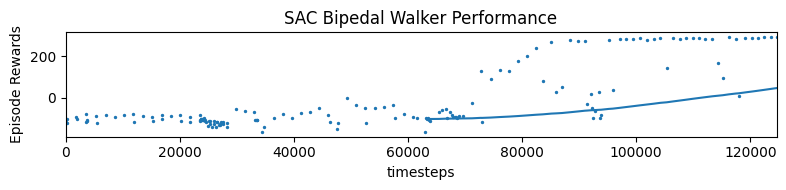

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
import os

# Use the exact path from your sidebar
local_log_dir = "./logs/sac_tuned/"

# Check if the file is actually there before plotting
if os.path.exists(os.path.join(local_log_dir, "monitor.csv")):
    results_plotter.plot_results(
        [local_log_dir],
        300000,
        results_plotter.X_TIMESTEPS,
        "SAC Bipedal Walker Performance"
    )
    plt.show()
else:
    print(f"❌ Still can't find it. Current files in {local_log_dir}:")
    print(os.listdir(local_log_dir))

In [9]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from gymnasium.wrappers import RecordVideo
import base64
import os
from pathlib import Path
from IPython import display as ipythondisplay

# --- CONFIGURATION: Define your Google Drive paths here ---
drive_base_path = "/content/drive/MyDrive/AISF_Project/"
model_name = "sac_bipedal_final.zip" # Or use your specific checkpoint filename
stats_name = "sac_vec_normalize.pkl"

model_path = os.path.join(drive_base_path, model_name)
stats_path = os.path.join(drive_base_path, stats_name)

# 1. Setup the Evaluation Environment
eval_env_id = "BipedalWalker-v3"
base_env = gym.make(eval_env_id, render_mode="rgb_array")
eval_env = DummyVecEnv([lambda: base_env])

# 2. LOAD the Normalization stats from Google Drive
if os.path.exists(stats_path):
    eval_env = VecNormalize.load(stats_path, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    print(f"✅ Normalization stats loaded from: {stats_path}")
else:
    print(f"❌ Error: {stats_path} not found. Please check your Drive folder.")

# 3. Wrap for Video Recording
video_folder = "./sac_eval_videos"
eval_env_video = RecordVideo(base_env, video_folder=video_folder, name_prefix="sac_walker")

# 4. Load the trained SAC Model from Google Drive
if os.path.exists(model_path):
    model = SAC.load(model_path)
    print(f"✅ Model loaded from: {model_path}")
else:
    print(f"❌ Error: {model_path} not found. Check if the training finished and saved.")

# 5. Run one episode to capture the video
obs, _ = eval_env_video.reset()
done = False
for _ in range(1600):
    # Use the loaded VecNormalize to scale the inputs correctly
    norm_obs = eval_env.normalize_obs(obs)
    action, _ = model.predict(norm_obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env_video.step(action)
    done = terminated or truncated

eval_env_video.close()

# 6. Display Video
def show_video(folder):
    video_files = list(Path(folder).glob("*.mp4"))
    if video_files:
        # Show the most recently created video file
        video_path = max(video_files, key=os.path.getctime)
        video_b64 = base64.b64encode(video_path.read_bytes())
        ipythondisplay.display(ipythondisplay.HTML(data=f'''
            <video alt="walker" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
            </video>'''))
    else:
        print("No video file found.")

show_video(video_folder)

✅ Normalization stats loaded from: /content/drive/MyDrive/AISF_Project/sac_vec_normalize.pkl
✅ Model loaded from: /content/drive/MyDrive/AISF_Project/sac_bipedal_final.zip


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/sac_eval_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Found data! Total Episodes: 164
Personal Best Episode: 293.99


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


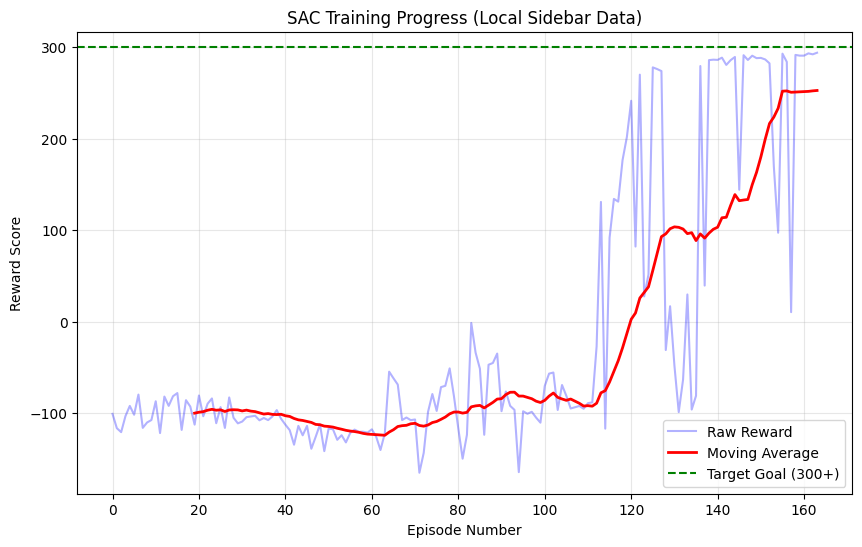

📂 Backup successful! monitor.csv copied to: /content/drive/MyDrive/AISF_Project/logs/


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import load_results
import os
import shutil

# 1. SET THE LOCAL PATH (from your sidebar)
local_log_path = "./logs/sac_tuned/"
# 2. SET THE BACKUP PATH (your permanent Drive)
drive_backup_path = "/content/drive/MyDrive/AISF_Project/logs/"

# --- STEP A: Plot from the Local Sidebar ---
if os.path.exists(os.path.join(local_log_path, "monitor.csv")):
    results_df = load_results(local_log_path)

    print(f"✅ Found data! Total Episodes: {len(results_df)}")
    print(f"Personal Best Episode: {results_df['r'].max():.2f}")

    plt.figure(figsize=(10, 6))
    rolling_mean = results_df['r'].rolling(window=20).mean()
    plt.plot(results_df.index, results_df['r'], alpha=0.3, label="Raw Reward", color='blue')
    plt.plot(results_df.index, rolling_mean, label="Moving Average", color='red', linewidth=2)
    plt.axhline(y=300, color='green', linestyle='--', label="Target Goal (300+)")

    plt.title("SAC Training Progress (Local Sidebar Data)")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- STEP B: Backup to Drive for Safety ---
    os.makedirs(drive_backup_path, exist_ok=True)
    shutil.copy(os.path.join(local_log_path, "monitor.csv"),
                os.path.join(drive_backup_path, "monitor.csv"))
    print(f"📂 Backup successful! monitor.csv copied to: {drive_backup_path}")

else:
    print(f"❌ Error: No monitor.csv found in {local_log_path}")
    print("Please check your sidebar folder path again.")

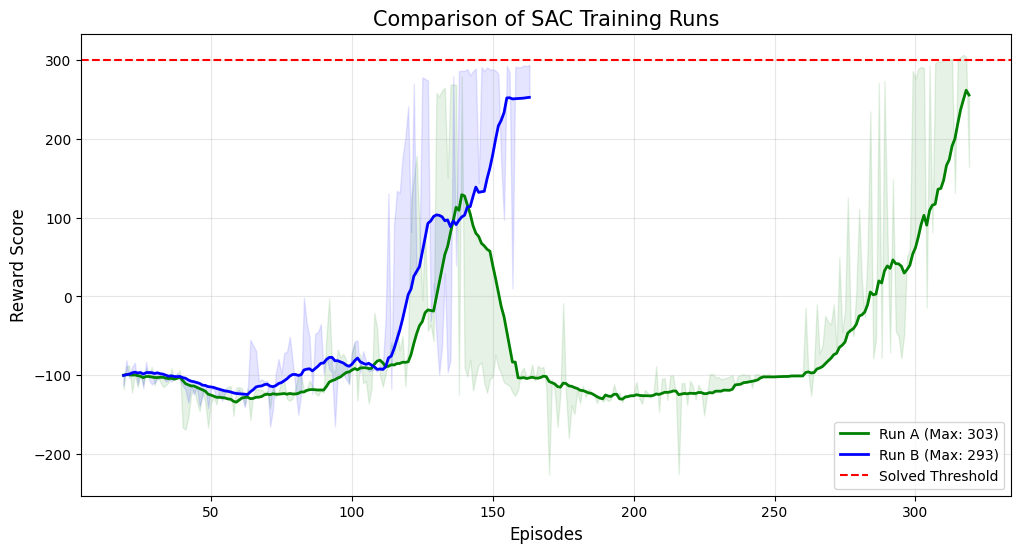

✅ Comparison graph generated successfully!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import load_results
import os

# --- PATHS (Update these to where your files are) ---
# Example: if they are in your Drive
path_run_1 = "/content/drive/MyDrive/AISF_Project/logs/run_303/"
path_run_2 = "/content/drive/MyDrive/AISF_Project/logs/run_293/"

def get_smoothed_data(path, window=20):
    results = load_results(path)
    return results['r'], results['r'].rolling(window=window).mean()

plt.figure(figsize=(12, 6))

try:
    # Load and Plot Run 1 (The 303 Run)
    raw1, smooth1 = get_smoothed_data(path_run_1)
    plt.plot(smooth1, label="Run A (Max: 303)", color='green', linewidth=2)
    plt.fill_between(range(len(raw1)), smooth1, raw1, color='green', alpha=0.1)

    # Load and Plot Run 2 (The 293 Run)
    raw2, smooth2 = get_smoothed_data(path_run_2)
    plt.plot(smooth2, label="Run B (Max: 293)", color='blue', linewidth=2)
    plt.fill_between(range(len(raw2)), smooth2, raw2, color='blue', alpha=0.1)

    # Styling the Graph
    plt.axhline(y=300, color='red', linestyle='--', label="Solved Threshold")
    plt.title("Comparison of SAC Training Runs", fontsize=15)
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Reward Score", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save the comparison for your report
    plt.savefig("sac_comparison_study.png", dpi=300)
    plt.show()

    print("✅ Comparison graph generated successfully!")

except Exception as e:
    print(f"❌ Error: {e}. Ensure both folders contain a file named 'monitor.csv'.")

In [12]:
import shutil
import os
from pathlib import Path

# 1. Define where the video is now (Local Colab) and where it should go (Drive)
local_video_folder = "./sac_eval_videos" # This must match your 'video_folder' in the recording script
drive_destination = "/content/drive/MyDrive/AISF_Project/"

# 2. Create the destination folder if it doesn't exist
os.makedirs(drive_destination, exist_ok=True)

# 3. Find all MP4 files in the local folder
video_files = list(Path(local_video_folder).glob("*.mp4"))

if video_files:
    # Sort by time to get the most recent video
    latest_video = max(video_files, key=os.path.getctime)

    # Define a clean name for your demo
    target_name = "BipedalWalker_SAC_Final_Demo.mp4"
    final_path = os.path.join(drive_destination, target_name)

    # 4. Copy the file
    shutil.copy(latest_video, final_path)

    print(f"✅ Success! Your video is now saved to Google Drive.")
    print(f"📍 Location: {final_path}")
else:
    print("❌ No MP4 files found. Check if your video recording script finished successfully.")

✅ Success! Your video is now saved to Google Drive.
📍 Location: /content/drive/MyDrive/AISF_Project/BipedalWalker_SAC_Final_Demo.mp4
